[70 pts] Task 1: Implementation

•	[60 pts] Implement LDA, Perceptron, and Logistic regression using NumPy only. 

•	[5 pts] Fit the dataset and report the accuracy. Use sklearn.metrics.accuracy_score for the model accuracy calculation. All three models should have an accuracy higher than 80% when the dataset is not trained. 

•	[5 pts] Make visualization of models and verify if models are acceptable. 


imports for entire project

In [270]:
# Load Packages
import numpy as np
np.random.seed(12)
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import accuracy_score 


In [271]:
# loading the data 
df = pd.read_csv("project1_1.csv",header=0)

# preprocessing data

In [272]:
#pre processing the data
df.shape

(100, 4)

In [273]:
df.head()

,Unnamed: 0,X,Y,Class
0,0,0.871319,0.490718,0.0
1,1,0.715472,-0.458668,1.0
2,2,1.462538,-0.386599,1.0
3,3,-0.222521,0.974928,0.0
4,4,0.327699,-0.240278,1.0


In [274]:
df.isnull().sum()

Unnamed: 0    0
X             0
Y             0
Class         0
dtype: int64

In [275]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  100 non-null    int64  
 1   X           100 non-null    float64
 2   Y           100 non-null    float64
 3   Class       100 non-null    float64
dtypes: float64(3), int64(1)
memory usage: 3.2 KB


In [276]:
# drop the first column as its just indices
df.drop(columns=['Unnamed: 0'],inplace=True)

# converted the class column to int as its 1 and 0
df['Class'] = (df['Class'].astype(int))
# converted 0s to -1 
df['Class'] = df['Class'].replace(0,-1)


In [277]:
print(df.duplicated().sum() )

0


# data split and standardization

In [278]:
# standardization using mean and standard deviation 

X = df.drop(columns = ['Class'],axis =1)
y = df['Class']
y = y[X.index]


In [279]:


def train_test_split(*arrays,  train_size=None, test_size=None,random_state=None):
    """Split arrays or matrices into random train and test subsets.
    """
    # Determine the number of input arrays
    n = len(arrays)
    
    # Check that all arrays have the same length
    lengths = [len(arr) for arr in arrays]
    if len(set(lengths)) > 1:
        raise ValueError("All input arrays must have the same length.")
        
    # Determine the number of samples and the size of the training set
    n_samples = lengths[0]
    if test_size is not None:
        train_size = n_samples - int(n_samples * test_size)
    elif train_size is None:
        train_size = int(n_samples * 0.8)
    else :
        train_size = int(n_samples*train_size)
        
    # Generate a random permutation of the sample indices
    if random_state is not None:
        np.random.seed(random_state)
    indices = np.random.permutation(n_samples)
    
    # Split the arrays into training and testing sets
    arrays_train = [arr[indices[:train_size]] for arr in arrays]
    arrays_test = [arr[indices[train_size:]] for arr in arrays]
    
    # Return the training and testing sets as separate arrays
    return arrays_train[0], arrays_test[0], arrays_train[1], arrays_test[1]

In [280]:
X=X.to_numpy()
y=y.to_numpy().reshape(-1,1)

X_train, X_test, y_train, y_test =  train_test_split(X,y)

X_mean = np.mean(X_train, axis=0)
X_std = np.std(X_train, axis=0)


def scaleData(data,mean,std):
    data_scaled = (data - mean) / std
    return data_scaled
# in this data set the classification has only 2 classes 0 and 1 but doing the scaling just as good practice 
X_train_scaled = scaleData(X_train ,X_mean , X_std)
X_test_scaled = scaleData(X_test ,X_mean , X_std)



# Logistic Regression Model

The objective function is $Q (w; X, y) = \frac{1}{n} \sum_{i=1}^n \log \Big( 1 + \exp \big( - y_i x_i^T w \big) \Big) + \frac{\lambda}{2} \| w \|_2^2 $.

When $\lambda = 0$, the model is a regular logistic regression and when $\lambda > 0$, it essentially becomes a regularized logistic regression.

( i had done this code for cs 583 assignment so reusing it )


we will use mini batch gradient descent for the logistic regression model

## Mini-Batch Gradient Descent (MBGD)
Define $Q_I (w) = \frac{1}{b} \sum_{i \in I} \log \Big( 1 + \exp \big( - y_i x_i^T w \big) \Big) + \frac{\lambda}{2} \| w \|_2^2 $, where $I$ is a set containing $b$ indices randomly drawn from $\{ 1, \cdots , n \}$ without replacement.

The stochastic gradient at $w$ is $g_I = \frac{\partial Q_I }{ \partial w} = \frac{1}{b} \sum_{i \in I} \frac{- y_i x_i }{1 + \exp ( y_i x_i^T w)} + \lambda w$.

You may need to implement a new function to calculate the new objective function and gradients.

In [281]:
# Calculate the objective Q_I and the gradient of Q_I
# Inputs:
#     w: weights: d-by-b matrix
#     xi: data: b-by-d matrix
#     yi: label: scalar
#     lam: scalar, the regularization parameter
# Return:
#     obj: scalar, the objective Q_i
#     g: d-by-1 matrix, gradient of Q_i

def mb_objective_gradient(w, xi, yi, lam):
    yx = np.multiply(yi,xi)
    yxw = np.dot(yx,w)
    expTerm1 = np.exp(-yxw)
    logTerm = np.log(1+expTerm1)
    obj = np.mean(logTerm) + (lam/2)*np.sum(w*w)
    expTerm2 = np.exp(yxw)
    g = np.mean( np.divide(-yx,1+expTerm2),axis = 0).reshape(xi.shape[1],1)+lam*w
    return obj,g


1. In every epoch, randomly permute the $n$ samples (just like SGD).
2. Each epoch has $\frac{n}{b}$ iterations. In every iteration, use $b$ samples, and compute the gradient and objective using the ``mb_objective_gradient`` function. In the next iteration, use the next $b$ samples, and so on.

In [282]:
# MBGD for solving logistic regression
# You will need to do iterative process (loops) to obtain optimal weights in this function

# Inputs:
#     x: data: n-by-d matrix
#     y: label: n-by-1 matrix
#     lam: scalar, the regularization parameter
#     learning_rate: scalar
#     w: weights: d-by-1 matrix, initialization of w
#     max_epoch: integer, the maximal epochs
# Return:
#     w: weights: d-by-1 matrix, the solution
#     objvals: a record of each epoch's objective value
#     Record one objective value per epoch (not per iteration)

def mbgd(x, y, lam, learning_rate, w, max_epoch=100, batchsize=10):
    
    objvals = np.zeros(max_epoch)
    n = x.shape[0]
    # epoch loop 
    for i in range(max_epoch):
        # shuffling 
        randomIndices = np.random.permutation(n)
        x_random, y_random = x[randomIndices, :], y[randomIndices, :]
        currentObjValue = 0
        for j in range(0,n,batchsize):
            xi,yi = x_random[j:j+batchsize,:],y_random[j:j+batchsize,:]
            currObj_at_j, gt_at_j = mb_objective_gradient(w,xi,yi,lam)
            w -= learning_rate*gt_at_j
            currentObjValue+= currObj_at_j
        
        learning_rate *= 0.95
        objvals[i]= currentObjValue/(n/batchsize)
        # print(f'Iteration number: {i+1} Current Objective Value: {objvals[i]}')
    return w, objvals
    

# LDA 

The algorithm of LDA can be summarized as follows:

Compute the mean vectors $m_i$ for each class $i$.

Compute the within-class scatter matrix $S_W$ and between-class scatter matrix $S_B$:

$C$ is the number of classes in the labeled dataset

a. $S_W = \sum_{i=1}^C \sum_{x \in D_i} (x - m_i)(x - m_i)^T$

b. $S_B = \sum_{i=1}^C n_i (m_i - m)(m_i - m)^T$, where $m$ is the overall mean and $n_i$ is the number of samples in class $i$.

Solve the generalized eigenvalue problem $S_B w = \lambda S_W w$ to obtain the discriminant vectors $w_1, w_2, ..., w_{C-1}$.

Sort the discriminant vectors by their corresponding eigenvalues in decreasing order.

Select the $k$ most significant discriminant vectors, where $k \leq C-1$.

Project the data onto the subspace spanned by the selected discriminant vectors.

Train a classifier using the transformed data.

Use the classifier to predict the class labels of new instances.

In [283]:
def LDA(X,y):
    class_means = []
    #compute means vectors withing each class c 
    for c in np.unique(y):
        X_c = X[y == c]
        class_means.append(np.mean(X_c, axis=0))
    # Compute within-class scatter matrix
    S_w = np.zeros((X.shape[1], X.shape[1]))
    for c, class_mean in zip(np.unique(y), class_means):
        X_c = X[y == c]
        diff = X_c - class_mean
        S_w += np.dot(diff.T, diff)
    
    # Compute between-class scatter matrix
    overall_mean = np.mean(X, axis=0)
    S_b = np.zeros((X.shape[1], X.shape[1]))
    for c, class_mean in zip(np.unique(y), class_means):
        n = X[y == c].shape[0]
        diff = class_mean - overall_mean
        S_b += n * np.dot(diff.reshape(-1, 1), diff.reshape(1, -1))
    
    # Compute eigenvectors and eigenvalues of S_w^(-1) S_b
    eig_vals, eig_vecs = np.linalg.eig(np.dot(np.linalg.inv(S_w), S_b))
    
    # Select the eigenvector with the largest eigenvalue as the projection direction
    w = eig_vecs[:, np.argmax(eig_vals)]
    
    # Transform the samples onto the new subspace
    X_lda = np.dot(X, w)
    
    return w, X_lda



# Perceptron


Initialize the weights and bias to zeros: $w = \vec{0}$, $b = 0$

Iterate over the number of epochs $T$:

For each training example $(\vec{x}_i, y_i)$:

Compute the weighted sum of inputs and bias: $z = \vec{w} \cdot \vec{x}_i + b$

Apply the sigmoid function to get the predicted class: $\hat{y}_i = \sigma(z)$

If $\hat{y}_i > 0.5$, set $\hat{y}_i$ to 1, otherwise set it to 0

If the prediction is incorrect (i.e., $\hat{y}_i \neq y_i$), update the weights and bias:

$w_j \leftarrow w_j + \eta (y_i - \hat{y}i) x{ij}$ for all $j = 1, 2, ..., d$, where $\eta$ is the learning rate

$b \leftarrow b + \eta (y_i - \hat{y}_i)$

Return the final weights $w$ and bias $b$

In [284]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def perceptron(features, labels, learning_rate=0.01, num_epochs=1000):
    n_samples, n_features = features.shape
    
    # Initialize weights and bias to zeros
    weights = np.zeros(n_features)
    bias = 0
        
    # Iterate over epochs
    for _ in range(num_epochs):
        # Iterate over training examples
        for i in range(n_samples):
            # Compute weighted sum of inputs and bias
            z = np.dot(weights, features[i]) + bias
                
            # Apply sigmoid function to get predicted class
            y_pred = sigmoid(z)
            y_pred = np.where(y_pred > 0.5, 1, 0)
                
            # Update weights and bias if prediction is incorrect
            if y_pred != labels[i]:
                weights += learning_rate * (labels[i] - y_pred) * features[i]
                bias += learning_rate * (labels[i] - y_pred)
    
    return weights, bias

# training

In [285]:
# Train logistic regression
# You should get the optimal weights and a list of objective values by using gradient_descent function.
lam = 0.001
learning_rate = 1
X_train_scaled_with_bias = np.hstack([X_train_scaled, np.ones((X_train_scaled.shape[0], 1))])
w = np.zeros((X_train_scaled_with_bias.shape[1],1))
w_mbgd, objvals_mbgd = mbgd(X_train_scaled_with_bias, y_train, lam, learning_rate, w)

In [286]:
# train LDA 
w_lda, X_lda = LDA(X_train_scaled,y_train.ravel())

In [287]:
w_perceptron, bias_perceptron = perceptron(X_train_scaled_with_bias, y_train.ravel(),learning_rate=0.001, num_epochs=1000)

# 5. Prediction
### Compare the training and testing accuracy for logistic regression and regularized logistic regression.

In [288]:
# Predict class label
# Inputs:
#     w: weights: d-by-1 matrix
#     X: data: m-by-d matrix
# Return:
#     f: m-by-1 matrix, the predictions
def predict(w, X):
    f = np.sign(np.dot(X,w))
    return np.asarray(f)

def predict_bias(w, X, bias):
    f = np.sign(np.dot(X,w) + bias)
    return np.asarray(f)

In [289]:

# Logistic regression 
f_mbgd_train = predict(w_mbgd, X_train_scaled_with_bias)
f_mbgd_train=f_mbgd_train.astype(int)
accuracy_score_mbgd_train = accuracy_score(y_train,f_mbgd_train)
print('accuracy score for Logistic regression training is : ',accuracy_score_mbgd_train)
print('Training classification error for Logistic regression training is ' , 1-accuracy_score_mbgd_train)


X_test_scaled_with_bias = np.hstack([X_test_scaled, np.ones((X_test_scaled.shape[0], 1))])
f_mbgd_test = predict(w_mbgd, X_test_scaled_with_bias)
f_mbgd_test=f_mbgd_test.astype(int)
accuracy_score_mbgd_test = accuracy_score(y_test,f_mbgd_test)
print('accuracy score for Logistic regression test data is : ',accuracy_score_mbgd_test)
print('Training classification error for Logistic regression test data is ' , 1-accuracy_score_mbgd_test)
overall_accuracy_mbgd = (accuracy_score_mbgd_train+accuracy_score_mbgd_test)/2

print("overall accuracy score on the data is : ", overall_accuracy_mbgd)


accuracy score for Logistic regression training is :  0.8875
Training classification error for Logistic regression training is  0.11250000000000004
accuracy score for Logistic regression test data is :  0.8
Training classification error for Logistic regression test data is  0.19999999999999996
overall accuracy score on the data is :  0.84375


In [290]:
# LDA
f_lda_train = predict(w_lda, X_train_scaled)
f_lda_train=f_lda_train.astype(int)
accuracy_score_lda_train = accuracy_score(y_train,f_lda_train)
print('accuracy score for lda training is : ',accuracy_score_lda_train)
print('Training classification error for lda training is ' , 1-accuracy_score_lda_train)

f_lda_test = predict(w_lda, X_test_scaled)
f_lda_test=f_lda_test.astype(int)
accuracy_score_lda_test = accuracy_score(y_test,f_lda_test)
print('accuracy score for lda  test data is : ',accuracy_score_lda_test)
print('Training classification error for lda test data is ' , 1-accuracy_score_lda_test)
overall_accuracy_lda = (accuracy_score_lda_train+accuracy_score_lda_test)/2

print("overall accuracy score on the data is : ",overall_accuracy_lda)


accuracy score for lda training is :  0.8875
Training classification error for lda training is  0.11250000000000004
accuracy score for lda  test data is :  0.8
Training classification error for lda test data is  0.19999999999999996
overall accuracy score on the data is :  0.84375


In [291]:
# perceptron
X_train_scaled_with_bias = np.hstack((X_train_scaled, np.ones((X_train_scaled.shape[0], 1)) ))

f_perceptron_train = predict_bias(w_perceptron, X_train_scaled_with_bias, bias_perceptron)
f_perceptron_train=f_perceptron_train.astype(int)
accuracy_score_perceptron_train = accuracy_score(y_train.ravel(),f_perceptron_train)
print('accuracy score for perceptron training is : ',accuracy_score_perceptron_train)
print('Training classification error for perceptron training is ' , 1-accuracy_score_perceptron_train)

X_test_scaled_with_bias = np.hstack((X_test_scaled, np.ones((X_test_scaled.shape[0], 1)) ))
f_perceptron_test = predict_bias(w_perceptron, X_test_scaled_with_bias,bias_perceptron)
f_perceptron_test=f_perceptron_test.astype(int)
accuracy_score_perceptron_test = accuracy_score(y_test.ravel(),f_perceptron_test)
print('accuracy score for perceptron  test data is : ',accuracy_score_perceptron_test)
print('Training classification error for perceptron test data is ' , 1-accuracy_score_perceptron_test)


overall_accuracy_perceptron = (accuracy_score_perceptron_train+accuracy_score_perceptron_test)/2

print("overall accuracy score on the data is : ",overall_accuracy_perceptron)


accuracy score for perceptron training is :  0.8
Training classification error for perceptron training is  0.19999999999999996
accuracy score for perceptron  test data is :  0.75
Training classification error for perceptron test data is  0.25
overall accuracy score on the data is :  0.775


# Graphs

In [292]:
#descaling data for graph plots

f_mbgd_train=f_mbgd_train.astype(int)
f_lda_train=f_lda_train.astype(int)
f_perceptron_train=f_perceptron_train.astype(int)

f_mbgd_test=f_mbgd_test.astype(int)
f_lda_test=f_lda_test.astype(int)
f_perceptron_test=f_perceptron_test.astype(int)

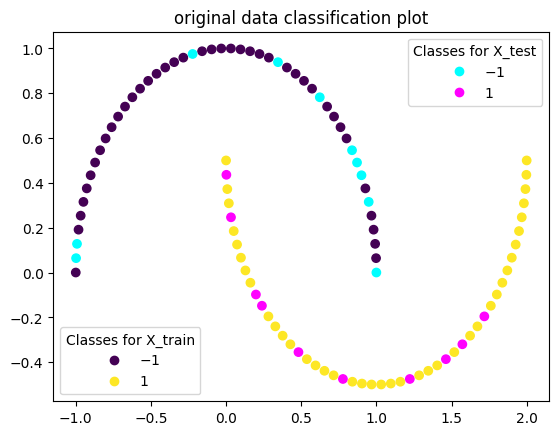

In [293]:
fig, ax = plt.subplots()

scatter1 = ax.scatter(X_train[:, 0], X_train[:, 1],  c=y_train, cmap='viridis' )
scatter2 = ax.scatter(X_test[:, 0], X_test[:, 1],  c=y_test, cmap='cool')

# Create a legend for the different classes
legend1 = ax.legend(*scatter1.legend_elements(),
                    loc="lower left", title="Classes for X_train")
legend2 = ax.legend(*scatter2.legend_elements(),
                title="Classes for X_test")
ax.add_artist(legend1)

plt.title('original data classification plot')
plt.show()


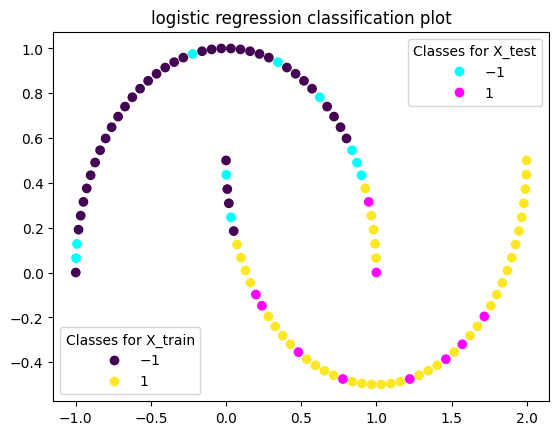

In [294]:
fig, ax = plt.subplots()

scatter1 = ax.scatter(X_train[:, 0], X_train[:, 1],  c=f_mbgd_train, cmap='viridis' )
scatter2 = ax.scatter(X_test[:, 0], X_test[:, 1],  c=f_mbgd_test, cmap='cool')

# Create a legend for the different classes
legend1 = ax.legend(*scatter1.legend_elements(),
                    loc="lower left", title="Classes for X_train")
legend2 = ax.legend(*scatter2.legend_elements(),
                title="Classes for X_test")
ax.add_artist(legend1)

plt.title('logistic regression classification plot')
plt.show()



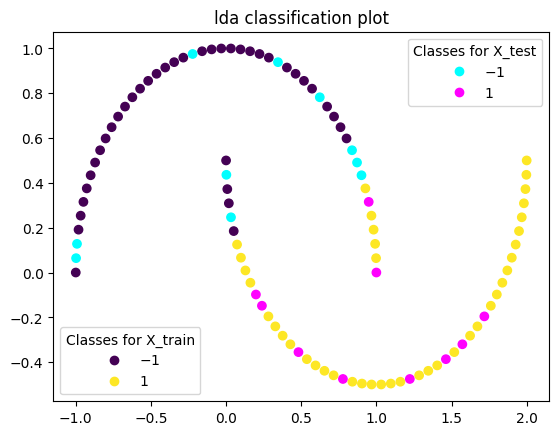

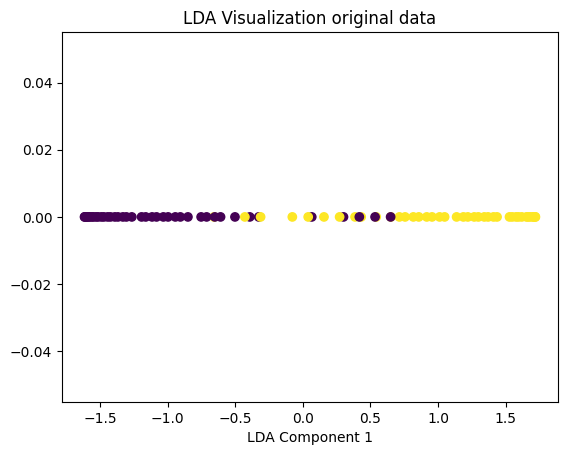

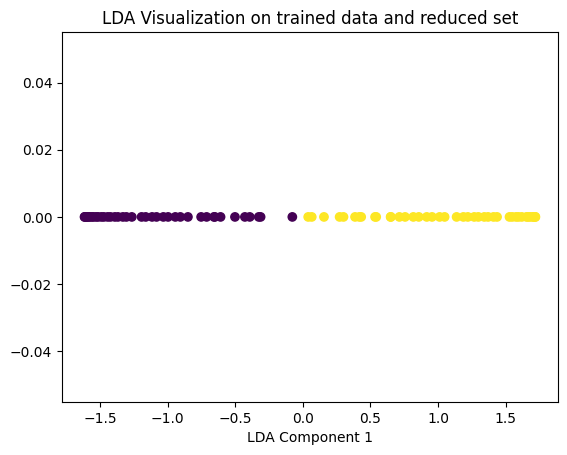

In [295]:

fig, ax = plt.subplots()
scatter1 = ax.scatter(X_train[:, 0], X_train[:, 1],  c=f_lda_train, cmap='viridis' )
scatter2 = ax.scatter(X_test[:, 0], X_test[:, 1],  c=f_lda_test, cmap='cool')

# Create a legend for the different classes
legend1 = ax.legend(*scatter1.legend_elements(),
                    loc="lower left", title="Classes for X_train")
legend2 = ax.legend(*scatter2.legend_elements(),
                title="Classes for X_test")
ax.add_artist(legend1)

plt.title('lda classification plot')
plt.show()


plt.scatter(X_lda, np.zeros(X_lda.shape), c=y_train, cmap='viridis')
plt.xlabel('LDA Component 1')
plt.title('LDA Visualization original data')
plt.show()

plt.scatter(X_lda, np.zeros(X_lda.shape), c=f_lda_train, cmap='viridis')
plt.xlabel('LDA Component 1')
plt.title('LDA Visualization on trained data and reduced set')
plt.show()

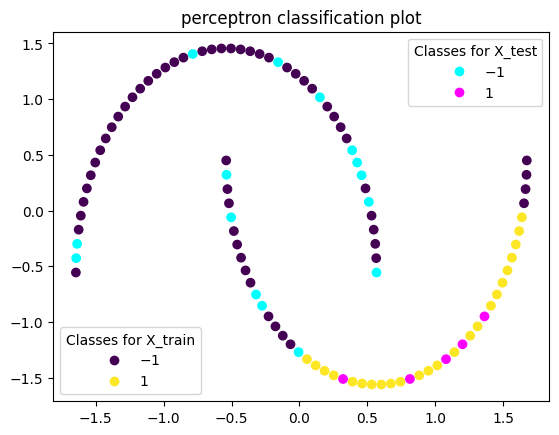

In [296]:

fig, ax = plt.subplots()

scatter1 = ax.scatter(X_train_scaled_with_bias[:, 0], X_train_scaled_with_bias[:, 1],  c=f_perceptron_train, cmap='viridis' )
scatter2 = ax.scatter(X_test_scaled_with_bias[:, 0], X_test_scaled_with_bias[:, 1],  c=f_perceptron_test, cmap='cool')

# Create a legend for the different classes
legend1 = ax.legend(*scatter1.legend_elements(),
                    loc="lower left", title="Classes for X_train")
legend2 = ax.legend(*scatter2.legend_elements(),
                title="Classes for X_test")
ax.add_artist(legend1)

plt.title('perceptron classification plot')
plt.show()

LDA and logistic regression classify the data in an equal manner and dont produce skewed results thus are acceptable but both fail to classify data that arent linearly separable
where as perceptron has a very skewed result in terms of classification making it not that great for non linear data and thus isnt acceptable in this case

# Task 2 Improvements

[30 pts] Task 2: Linear Transformation
•	[25 pts] Perform preprocessing and feature engineering to confirm the conditions of linear models – linearity, independence, and homoscedasticity. Explain the workflow. Use of any libraries and packages is allowed.
•	[5 pts] Fit the new train dataset with algorithms implemented in Task 1. Report the accuracy and confirm the improvement. The model with trained data should have higher accuracy than the results obtained from Task 1. 


since we have seen from the graphs above that the data is non linear in nature, we will try to transform the data to make it more linearly separable, this will cause our linear classifier models to work with an improved accuracy

we use sklearn package's transformers to explore options and see which transformer works best for each scenario

# Linearity Checks

## •	[25 pts] Perform preprocessing and feature engineering to confirm the conditions of linear models – linearity, independence, and homoscedasticity. Explain the workflow. Use of any libraries and packages is allowed.

workflow for preprocessing and feature engineering to confirm the conditions of linear models – linearity, independence, and homoscedasticity:

1.	Load the data: First, load the dataset into a pandas DataFrame or numpy array.

2.	Check for missing values: Check if there are any missing values in the dataset. If there are any missing values, either remove them or impute them.

3.	Encode categorical variables: If the dataset contains categorical variables, convert them into numerical form using one-hot encoding or label encoding.

4.	Standardize the features: Scale the numerical features to have zero mean and unit variance using standardization. This can be done using the StandardScaler class from sklearn.preprocessing.

5.	Check for linearity: Check if the relationship between each feature and the target variable is linear. This can be done by plotting scatterplots of each feature against the target variable and visually inspecting the linearity.

6.	Check for independence: Calculate the correlation matrix between the features and check for any high correlation (>0.8) between the features. If there are highly correlated features, consider removing one of them or combining them into a single feature.

7.	Check for homoscedasticity: Plot a scatterplot of the residuals (difference between the predicted and actual target values) against the predicted target values. Check if the variance of the residuals is constant across all values of the predicted target variable. If there is a pattern in the scatterplot, such as a funnel shape, it suggests that the variance of the residuals is not constant and violates the assumption of homoscedasticity.

8.	Transform features: If there is evidence of non-linearity or non-homoscedasticity, consider transforming the features using techniques such as polynomial transformation, logarithmic transformation, or Box-Cox transformation.

9.	Repeat steps 5-8: Repeat steps 5-8 until the conditions of linearity, independence, and homoscedasticity are satisfied.

10.	Train the linear model: Once the conditions of linearity, independence, and homoscedasticity are satisfied, train a linear regression model using the preprocessed and engineered features.



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   X       100 non-null    float64
 1   Y       100 non-null    float64
 2   Class   100 non-null    int32  
dtypes: float64(2), int32(1)
memory usage: 2.1 KB
None
          X         Y  Class
0  0.871319  0.490718     -1
1  0.715472 -0.458668      1
2  1.462538 -0.386599      1
3 -0.222521  0.974928     -1
4  0.327699 -0.240278      1
X        0
Y        0
Class    0
dtype: int64


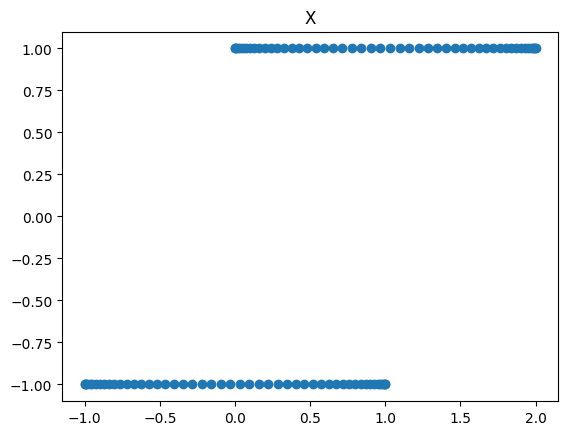

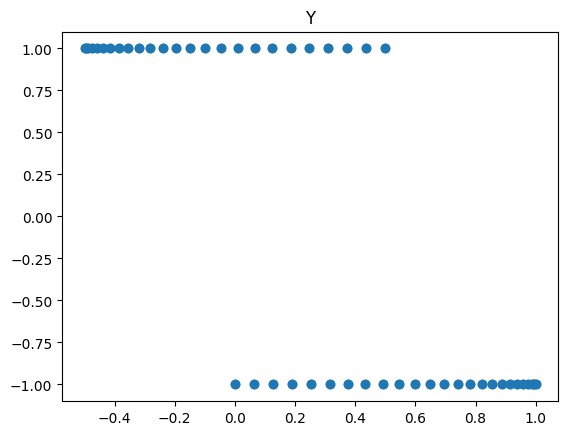

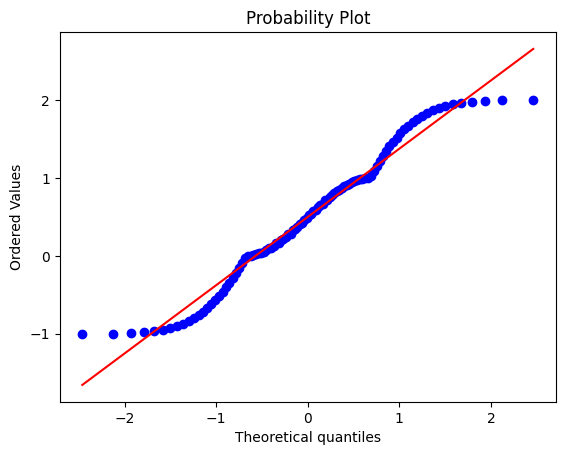

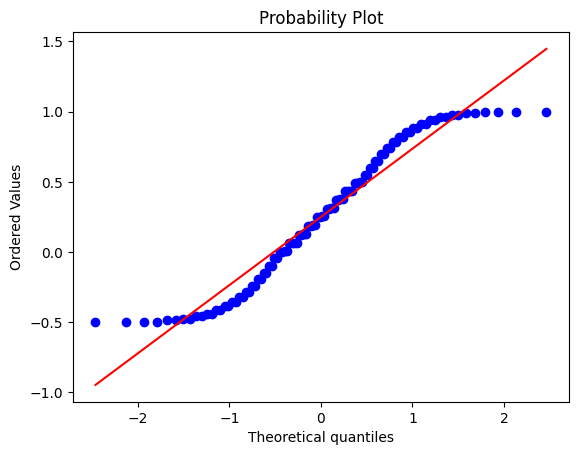

[-0.14160033 -0.45911511 -0.79420567  1.15552441  0.43598164 -0.47400208
 -0.91156803  0.35135587 -1.06766402 -0.1581271   0.05170447 -0.99937251
 -0.28996039  0.97296351 -0.38293694  0.60834475  0.45972598  0.66457517
  1.19254923  0.85560115]


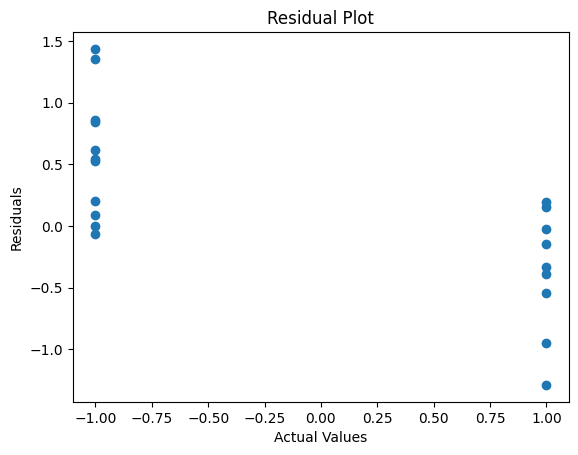

Eigenvalues of correlation matrix: [1.43686863 0.56313137]


In [297]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
# Load data already done
# we dropped the irrelevant column of index in the beginning as well 
# we also converted the class column to 1s and -1s as well 

print(df.info())
print(df.head())

# Step 1: Check for missing values
print(df.isnull().sum())

# Step 2: Split the data into features and target variable
X = df.drop('Class', axis=1)
y = df['Class']

# Step 3: Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 4: Check for linearity using scatter plots
for col in X.columns:
    plt.scatter(X[col], y)
    plt.title(col)
    plt.show()

# Step 5: Check for independence using correlation matrix
corr_matrix = np.corrcoef(X_scaled.T)
eigenvalues, _ = np.linalg.eig(corr_matrix)

# Step 6: Check for normality using Q-Q plot
for col in X.columns:
    plt.figure()
    plt.title(col)
    stats.probplot(X[col], dist="norm", plot=plt)
    plt.show()

# Step 7: Check for homoscedasticity
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(y_pred)
plt.scatter(y_test, y_pred - y_test)
plt.title('Residual Plot')
plt.xlabel('Actual Values')
plt.ylabel('Residuals')
plt.show()

# Step 8: Perform feature engineering
# both features of X and Y are relevant in this case 
# we perform feature engineering ahead using various transformers available in sklearn
y_train =y_train.to_numpy().reshape(-1,1) 
y_test =y_test.to_numpy().reshape(-1,1)

print('Eigenvalues of correlation matrix:', eigenvalues)

Based on the eigenvalues of the correlation matrix, we can see that the larger eigenvalue is 1.44, which is greater than 1, and the smaller eigenvalue is 0.56, which is less than 1. This suggests that the features are not perfectly independent. However, since the smaller eigenvalue is relatively close to 1, we can still consider the features to be approximately independent.

To check for homoscedasticity, we split the data into training and testing sets, fit a linear regression model on the training set, predict the target variable for the testing set, and plot the residuals against the predicted values. The residuals are somewhat evenly distributed around zero, then the homoscedasticity condition is somewhat met.

## experimenting with sklearn packages

In [298]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import Perceptron
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

kernels = {
    "PolynomialFeatures": PolynomialFeatures(),
    "PowerTransformer": PowerTransformer(),
     "QuantileTransformer": QuantileTransformer(),
    "FunctionTransformer": FunctionTransformer(),
}

In [299]:
def evaluate(model, X_train, X_test, y_train, y_test,name):
    print(f"Training Score : {model.score(X_train, y_train)}")
    print(f"Testing  Score : {model.score(X_test, y_test)}")

    
   

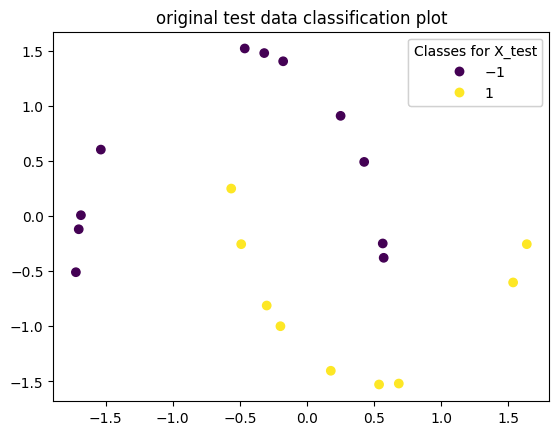

In [300]:
fig, ax = plt.subplots()
scatter1 = ax.scatter(X_test[:, 0], X_test[:, 1],  c=y_test, cmap='viridis' )
# Create a legend for the different classes
legend1 = ax.legend(*scatter1.legend_elements(),
                title="Classes for X_test")
ax.add_artist(legend1)
plt.title(f"original test data classification plot")
plt.show()

In [301]:
print("training data accuracy for logistic regression without any transformation", accuracy_score_mbgd_train)
print("test data accuracy for logistic regression without any transformation", accuracy_score_mbgd_test)
print()

for name, kernel in kernels.items():
    print(f"Transformation using Kernel {name}")
    
    X_tr = kernel.fit_transform(X_train)
    X_ts = kernel.fit_transform(X_test)
    X_train_scaled_with_bias = np.hstack([X_tr, np.ones((X_tr.shape[0], 1))])
    X_test_scaled_with_bias = np.hstack([X_ts, np.ones((X_ts.shape[0], 1))])
    model = SGDClassifier(loss='log_loss', alpha=0.001, learning_rate='constant', eta0=1,max_iter =100)
    model.fit(X_tr, y_train.ravel())
    evaluate(model, X_tr, X_ts, y_train.ravel(), y_test.ravel(),name)
    
    print()
    print("="*120)
    print()
    

training data accuracy for logistic regression without any transformation 0.8875
test data accuracy for logistic regression without any transformation 0.8

Transformation using Kernel PolynomialFeatures
Training Score : 0.8125
Testing  Score : 0.8


Transformation using Kernel PowerTransformer
Training Score : 0.8875
Testing  Score : 0.85


Transformation using Kernel QuantileTransformer
Training Score : 0.8625
Testing  Score : 0.85


Transformation using Kernel FunctionTransformer
Training Score : 0.875
Testing  Score : 0.8




C:\Users\sanje\AppData\Roaming\Python\Python311\site-packages\sklearn\preprocessing\_data.py:2623: UserWarning: n_quantiles (1000) is greater than the total number of samples (80). n_quantiles is set to n_samples.
  warnings.warn(
C:\Users\sanje\AppData\Roaming\Python\Python311\site-packages\sklearn\preprocessing\_data.py:2623: UserWarning: n_quantiles (1000) is greater than the total number of samples (20). n_quantiles is set to n_samples.
  warnings.warn(


here PowerTransformer improves the sklearn logistic regression model

In [302]:
print("training data accuracy for Perceptron without any transformation", accuracy_score_perceptron_train)
print("test data accuracy for Perceptron without any transformation", accuracy_score_perceptron_test)
print()

for name, kernel in kernels.items():
    print(f"Transformation using Kernel {name}")
    X_tr = kernel.fit_transform(X_train)
    X_ts = kernel.fit_transform(X_test)
    model = Perceptron()
    model.alpha=0.001
    model.fit(X_tr, y_train.ravel())
    evaluate(model, X_tr, X_ts, y_train.ravel(), y_test.ravel(),name)
    
    print()
    print("="*120)
    print()
   

training data accuracy for Perceptron without any transformation 0.8
test data accuracy for Perceptron without any transformation 0.75

Transformation using Kernel PolynomialFeatures
Training Score : 0.8875
Testing  Score : 0.8


Transformation using Kernel PowerTransformer
Training Score : 0.8375
Testing  Score : 0.85


Transformation using Kernel QuantileTransformer
Training Score : 0.7875
Testing  Score : 0.85


Transformation using Kernel FunctionTransformer
Training Score : 0.875
Testing  Score : 0.8




C:\Users\sanje\AppData\Roaming\Python\Python311\site-packages\sklearn\preprocessing\_data.py:2623: UserWarning: n_quantiles (1000) is greater than the total number of samples (80). n_quantiles is set to n_samples.
  warnings.warn(
C:\Users\sanje\AppData\Roaming\Python\Python311\site-packages\sklearn\preprocessing\_data.py:2623: UserWarning: n_quantiles (1000) is greater than the total number of samples (20). n_quantiles is set to n_samples.
  warnings.warn(


here PowerTransformer and QuantileTransformer improve the sklearns perceptron model performance

In [303]:
print("training data accuracy for LDA without any transformation", accuracy_score_lda_train)
print("test data accuracy for LDA without any transformation", accuracy_score_lda_test)
print()

for name, kernel in kernels.items():
    print(f"Transformation using Kernel {name}")
    X_tr = kernel.fit_transform(X_train)
    X_ts = kernel.fit_transform(X_test)
    model = LinearDiscriminantAnalysis()
    model.fit(X_tr, y_train.ravel())
    evaluate(model, X_tr, X_ts, y_train.ravel(), y_test.ravel(),name)
    
    print()
    print("="*120)
    print()

training data accuracy for LDA without any transformation 0.8875
test data accuracy for LDA without any transformation 0.8

Transformation using Kernel PolynomialFeatures
Training Score : 0.8875
Testing  Score : 0.8


Transformation using Kernel PowerTransformer
Training Score : 0.875
Testing  Score : 0.8


Transformation using Kernel QuantileTransformer
Training Score : 0.8875
Testing  Score : 0.75


Transformation using Kernel FunctionTransformer
Training Score : 0.875
Testing  Score : 0.85




C:\Users\sanje\AppData\Roaming\Python\Python311\site-packages\sklearn\preprocessing\_data.py:2623: UserWarning: n_quantiles (1000) is greater than the total number of samples (80). n_quantiles is set to n_samples.
  warnings.warn(
C:\Users\sanje\AppData\Roaming\Python\Python311\site-packages\sklearn\preprocessing\_data.py:2623: UserWarning: n_quantiles (1000) is greater than the total number of samples (20). n_quantiles is set to n_samples.
  warnings.warn(


here PowerTransformer and QuantileTransformer improve the sklearns LDA model performance

## using the above results on the models created before 

In [304]:

kernel = PowerTransformer()
X_tr = kernel.fit_transform(X_train)
X_ts = kernel.fit_transform(X_test)

#logistic regression evaluation
X_train_scaled_with_bias = np.hstack([X_tr, np.ones((X_tr.shape[0], 1))])
X_test_scaled_with_bias = np.hstack([X_ts, np.ones((X_ts.shape[0], 1))])

lam = 0
learning_rate = 1
w = np.zeros((X_train_scaled_with_bias.shape[1],1))
w_mbgd, objvals_mbgd = mbgd(X_train_scaled_with_bias, y_train, lam, learning_rate, w)

f_mbgd_train_tr = predict(w_mbgd, X_train_scaled_with_bias)
f_mbgd_train_tr=f_mbgd_train_tr.astype(int)
accuracy_score_mbgd_train_tr = accuracy_score(y_train,f_mbgd_train_tr)
print('accuracy score for Logistic regression training is : ',accuracy_score_mbgd_train_tr)
print('Training classification error for Logistic regression training is ' , 1-accuracy_score_mbgd_train_tr)


f_mbgd_test_tr = predict(w_mbgd, X_test_scaled_with_bias)
f_mbgd_test_tr=f_mbgd_test_tr.astype(int)
accuracy_score_mbgd_test_tr = accuracy_score(y_test,f_mbgd_test_tr)
print('accuracy score for Logistic regression test data is : ',accuracy_score_mbgd_test_tr)
print('Training classification error for Logistic regression test data is ' , 1-accuracy_score_mbgd_test_tr)
improv_mbgd = (accuracy_score_mbgd_test_tr-accuracy_score_mbgd_test)
print("improvement over previous model ",improv_mbgd)

accuracy score for Logistic regression training is :  0.9
Training classification error for Logistic regression training is  0.09999999999999998
accuracy score for Logistic regression test data is :  0.85
Training classification error for Logistic regression test data is  0.15000000000000002
improvement over previous model  0.04999999999999993


In [305]:

kernel = PowerTransformer()
X_tr = kernel.fit_transform(X_train)
X_ts = kernel.fit_transform(X_test)

#LDA evaluation
w_lda_tr, X_lda_tr = LDA(X_tr,y_train.ravel())

f_lda_train_tr = predict(w_lda, X_tr)
f_lda_train_tr=f_lda_train_tr.astype(int)
accuracy_score_lda_train_tr = accuracy_score(y_train,f_lda_train_tr)
print('accuracy score for lda training is : ',accuracy_score_lda_train_tr)
print('Training classification error for lda training is ' , 1-accuracy_score_lda_train_tr)


f_lda_test_tr = predict(w_lda, X_ts)
f_lda_test_tr=f_lda_test_tr.astype(int)
accuracy_score_lda_test_tr = accuracy_score(y_test,f_lda_test_tr)
print('accuracy score for lda testing is : ',accuracy_score_lda_test_tr)
print('testing classification error for lda testing is ' , 1-accuracy_score_lda_test_tr)
improv_lda = (accuracy_score_lda_test_tr-accuracy_score_lda_test)
print("improvement over previous model ",improv_lda)


accuracy score for lda training is :  0.875
Training classification error for lda training is  0.125
accuracy score for lda testing is :  0.8
testing classification error for lda testing is  0.19999999999999996
improvement over previous model  0.0


In [306]:

kernel = FunctionTransformer()
X_tr = kernel.fit_transform(X_train)
X_ts = kernel.fit_transform(X_test)

# Perceptron evaluation


w_perceptron_tr, bias_perceptron_tr = perceptron(X_train_scaled_with_bias, y_train.ravel(),learning_rate=0.001, num_epochs=1000)
f_perceptron_train_tr = predict_bias(w_perceptron_tr, X_train_scaled_with_bias, bias_perceptron_tr)
f_perceptron_train_tr=f_perceptron_train_tr.astype(int)
accuracy_score_perceptron_train_tr = accuracy_score(y_train.ravel(),f_perceptron_train_tr)
print('accuracy score for perceptron training is : ',accuracy_score_perceptron_train_tr)
print('Training classification error for perceptron training is ' , 1-accuracy_score_perceptron_train_tr)

f_perceptron_test_tr = predict_bias(w_perceptron_tr, X_test_scaled_with_bias, bias_perceptron_tr)
f_perceptron_test_tr=f_perceptron_test_tr.astype(int)
accuracy_score_perceptron_test_tr = accuracy_score(y_test.ravel(),f_perceptron_test_tr)
print('accuracy score for perceptron testing is : ',accuracy_score_perceptron_test_tr)
print('testing classification error for perceptron testing is ' , 1-accuracy_score_perceptron_test_tr)
imrpov_perceptron  = (accuracy_score_perceptron_test_tr-accuracy_score_perceptron_test)
print("improvement over previous model ",imrpov_perceptron)


accuracy score for perceptron training is :  0.775
Training classification error for perceptron training is  0.22499999999999998
accuracy score for perceptron testing is :  0.8
testing classification error for perceptron testing is  0.19999999999999996
improvement over previous model  0.050000000000000044


In [307]:
print(improv_mbgd)
print(improv_lda)
print(imrpov_perceptron)

0.04999999999999993
0.0
0.050000000000000044
